### Data EDA

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
import tqdm.notebook as tqdm
import torch

In [24]:
#load ecg data
import wfdb

# Specify the file path without the extension (it will look for .dat and .hea automatically)
record_name = ecg_dir = "/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0661"

# Load the signal and header info
record = wfdb.rdrecord(record_name)  # Loads both .dat and .hea files
signal = record.p_signal  # Get the ECG signal (numpy array)
fields = record.__dict__  # Access additional metadata (like sampling frequency)

print("Signal Shape:", signal.shape)

#trim
fs = fields['fs']
trim_seconds = 35
trim_samples = int(fs * trim_seconds)

signal = signal[trim_samples : -trim_samples]
print(signal.shape)
fields['sig_len'] = signal.shape

# Display basic info
print("Signal Shape:", signal.shape)
print("Sampling Frequency:", record.fs)
print("Channel Names:", record.sig_name)


Signal Shape: (17268007, 2)
(17254007, 2)
Signal Shape: (17254007, 2)
Sampling Frequency: 200
Channel Names: ['X', 'Y']


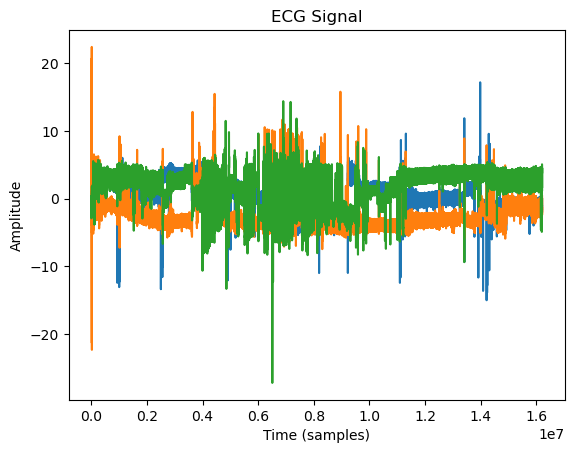

In [17]:
plt.plot(signal)
plt.title("ECG Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

### Model

In [1]:
import importlib.metadata
import json
import logging
import os
import re
import tempfile
import time
import ast
from pathlib import Path
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Type, TypeVar, Union, Collection

Floats = Union[float, List[float]]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class XResNet1D(nn.Module):
    def __init__(self, in_channels=3, num_classes=150, layers=[2, 2, 2, 2]):
        super(XResNet1D, self).__init__()

        self.inplanes = 64
        self.conv1 = nn.Conv1d(in_channels,out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Define ResNet blocks
        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        layers = []
        layers.append(self._residual_block(self.inplanes, planes, stride))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(self._residual_block(planes, planes))
        return nn.Sequential(*layers)

    def _residual_block(self, in_planes, out_planes, stride=1):
        return nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(out_planes),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_planes, out_planes, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(out_planes)
        )

    def forward(self, x):
        x = self.conv1(x)  # Initial Conv Layer
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # Residual Blocks
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)  # Global Pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)  # Classification Head
        return x

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=150, projection_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 150)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(150, projection_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Attach to model
encoder = XResNet1D(in_channels=3, num_classes=150)  # Output raw features
model = nn.Sequential(encoder, ProjectionHead(input_dim=150, projection_dim=64))

print(model)


### Dataloader

In [ ]:
#TRANSFORMS TAKEN FROM ESI

import math
import numpy as np
import torch
import torch.optim as optim


class Jitter(object):
    def __init__(self, sigma=0.03):
        self.sigma = sigma

    def jitter(self, x, sigma):
        # Jitter is added to every point in the time series data, so no change is needed based on channel_first
        return x + np.random.normal(loc=0., scale=sigma, size=x.shape)
    
    def __call__(self, x):
        return self.jitter(x, self.sigma)


class Scaling(object):
    def __init__(self, sigma=0.1, channel_first=False):
        self.sigma = sigma
        self.channel_first = channel_first

    def scaling(self, x, sigma):
        if self.channel_first:
            # For (B, C, L), generate a factor for each channel and broadcast across L
            factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0], 1))
        else:
            # For (B, L, C), generate a factor for each channel and broadcast across L
            factor = np.random.normal(loc=1., scale=sigma, size=(1, x.shape[1]))
        
        return np.multiply(x, factor)
    
    def __call__(self, x):
        return self.scaling(x, self.sigma)
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sample = torch.Tensor(sample)
        return sample
    

class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]
    
def normalize(signal):
    mean = signal.mean(dim=-1, keepdim=True)  # Mean along time axis
    std = signal.std(dim=-1, keepdim=True)
    return (signal - mean) / (std + 1e-6)  # Avoid division by zero


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import wfdb
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HolterECGLoader(Dataset):
    def __init__(self, csv_file, ecg_dir, segment_length=5, augmentation=True):
        """
        ECG Dataset that returns one 5-second segment per call and moves sequentially to the next patient.

        Args:
            csv_file (str): Path to the CSV file containing metadata.
            ecg_dir (str): Path to the directory containing ECG records.
            segment_length (int): Length of ECG segments in seconds.
            augmentation (bool): Whether to apply augmentation.
        """
        super().__init__()
        self.dataset = pd.read_csv(csv_file, index_col=0)
        self.label_dict = {0: 0, 3: 1, 6: 2}
        self.ecg_dir = ecg_dir
        self.segment_length = segment_length  # Length of segment in seconds
        self.augmentation = augmentation
        self.current_patient_idx = 0  # Track which patient is being processed
        self.current_segment_idx = 0  # Track which segment within the patient is being returned

        self.augment = transforms.Compose([
            Jitter(0.003),
            Scaling(0.003),
            ToTensor(),
        ])
        self.transform = TwoCropTransform(self.augment)

    def __len__(self):
        """
        Returns the number of patients since the dataloader will iterate per patient, not per segment.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Returns one 5-second segment from the current patient's ECG.
        Moves to the next patient after all segments of the current one are processed.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # If all segments of the current patient are processed, move to the next patient
        if self.current_segment_idx == 0:
            self.current_patient_idx = idx  
            ecg_filename = os.path.join(self.ecg_dir, self.dataset.iloc[idx, 0])
            self.label = self.label_dict[self.dataset.iloc[idx, 4]]

            # Load patient ECG file
            record = wfdb.rdrecord(ecg_filename)
            self.signal = record.p_signal  
            self.fs = record.fs  

            # Trim first and last 30 seconds
            trim_samples = self.fs * 30
            self.signal = self.signal[trim_samples:-trim_samples]

            # Compute segment size
            self.segment_samples = self.segment_length * self.fs
            self.total_length = self.signal.shape[0]
            self.num_segments = self.total_length // self.segment_samples 

        # Extract the current segment
        start_idx = self.current_segment_idx * self.segment_samples
        end_idx = start_idx + self.segment_samples

        if end_idx > self.total_length:
            segment = np.pad(self.signal[start_idx:], ((0, end_idx - self.total_length), (0, 0)), mode='constant')
        else:
            segment = self.signal[start_idx:end_idx]

        # Convert to tensor
        segment = torch.tensor(segment, dtype=torch.float32).T  # Shape: (channels, segment_length_samples)

        # Apply augmentation
        if self.augmentation:
            segment = self.transform(segment)
            segment[0] = normalize(segment[0])
            segment[1] = normalize(segment[1])
        else:
            segment = ToTensor()(segment)
            segment = normalize(segment)

        # Move to the next segment
        self.current_segment_idx += 1

        # If all segments are processed, reset segment index to start fresh on next call
        if self.current_segment_idx >= self.num_segments:
            self.current_segment_idx = 0  # Reset for the next patient

        return segment, self.label


In [32]:
import torch
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class SIMCLR_loss(nn.Module):
    def __init__(self, temperature=0.07, base_temperature=0.07):
        super(SIMCLR_loss, self).__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, z1, z2):
        device = z1.device
        batch_size = z1.shape[0]

        # Normalize embeddings
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        features = torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1)  

        # Flatten feature representations
        contrast_count = features.shape[1]  # Should be 2 for SimCLR
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0) 
        
        # Use all features as anchors
        anchor_feature = contrast_feature
        anchor_count = contrast_count

        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        mask = mask.repeat(anchor_count, contrast_count)

        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )

        mask = mask * logits_mask

        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss


In [33]:
csv_path = "/projects/bdlo/music-sudden-cardiac-death/subject-info-cleaned.csv"
ecg_dir = "/projects/bdlo/music-sudden-cardiac-death/Holter_ECG"

holterecg_dataset = HolterECGLoader(csv_file=csv_path, ecg_dir=ecg_dir, augmentation = True)

#test - works
#signal, label = holterecg_dataset[0]
#sample_idx = 0 

## Training Step

In [34]:
!nvidia-smi

Tue Feb 25 02:15:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:85:00.0 Off |                    0 |
|  0%   42C    P0             79W /  300W |     733MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [35]:
from tqdm.notebook import tqdm

from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F


def contrastive_accuracy(z1, z2):
    """
    Computes SimCLR-style accuracy based on cosine similarity.
    """
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    sim_matrix = torch.matmul(z1, z2.T)  # Compute cosine similarity
    batch_size = z1.shape[0]
    labels = torch.arange(batch_size).to(z1.device)  # Identity labels

    # Find the most similar pair for each instance
    pred = sim_matrix.argmax(dim=1)
    acc = (pred == labels).float().mean().item()  # Compute accuracy
    return acc


In [36]:
train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(holterecg_dataset))), test_size=0.2, stratify=holterecg_dataset.dataset["Cause of death"])
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)

In [37]:
train_loader = DataLoader(holterecg_dataset, batch_size=50, shuffle=True, num_workers=2, pin_memory=True, collate_fn=None)

In [38]:
#getting ready
device = "cuda:0"
model = model.to(device)

# Training parameters
epochs = 100
warmup_epochs = 10
base_lr = 0.03
final_lr = 0.1

In [39]:


# Learning Rate Warmup + Scheduler
def get_lr(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs * base_lr  
    return final_lr 

optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr)
criterion = SIMCLR_loss()

# Training Loop
for epoch in range(epochs):
    print(f"\n[EPOCH {epoch + 1}/{epochs}] - LR: {scheduler.get_last_lr()[0]:.6f}")
    
    epoch_loss = 0
    epoch_acc = 0
    num_batches = 0

    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        view1, view2 = images[0].to(device).float(), images[1].to(device).float()

        # Forward pass
        z1 = model(view1)  
        z2 = model(view2)
        
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        loss = criterion(z1, z2)

        # Compute accuracy
        acc = contrastive_accuracy(z1, z2)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        epoch_loss += loss.item()
        epoch_acc += acc
        num_batches += 1

    # Compute epoch-wise average loss & accuracy
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"[EPOCH {epoch+1}] Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

    # Step LR scheduler
    scheduler.step()






[EPOCH 1/100] - LR: 0.000090


Epoch 1 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0484
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0116
[EPOCH 1] Loss: 1.3367, Accuracy: 1.0000

[EPOCH 2/100] - LR: 0.000180


/u/irsyadadam/.conda/envs/ecg_llm/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853099/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 2 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0515
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0902
[EPOCH 2] Loss: 0.2524, Accuracy: 1.0000

[EPOCH 3/100] - LR: 0.000270


Epoch 3 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0645
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0655
[EPOCH 3] Loss: 0.1031, Accuracy: 1.0000

[EPOCH 4/100] - LR: 0.000360


Epoch 4 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0901
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0637
[EPOCH 4] Loss: 0.0826, Accuracy: 1.0000

[EPOCH 5/100] - LR: 0.000450


Epoch 5 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0121
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0343
[EPOCH 5] Loss: 0.0434, Accuracy: 1.0000

[EPOCH 6/100] - LR: 0.000540


Epoch 6 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0780
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0865
[EPOCH 6] Loss: 0.0617, Accuracy: 1.0000

[EPOCH 7/100] - LR: 0.000630


Epoch 7 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0701
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0818
[EPOCH 7] Loss: 0.0408, Accuracy: 1.0000

[EPOCH 8/100] - LR: 0.000720


Epoch 8 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0686
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0204
[EPOCH 8] Loss: 0.0509, Accuracy: 1.0000

[EPOCH 9/100] - LR: 0.000810


Epoch 9 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0882
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0865
[EPOCH 9] Loss: 0.0468, Accuracy: 1.0000

[EPOCH 10/100] - LR: 0.000900


Epoch 10 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0672
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0664
[EPOCH 10] Loss: 0.0714, Accuracy: 1.0000

[EPOCH 11/100] - LR: 0.003000


Epoch 11 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0204/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0288

[EPOCH 11] Loss: 0.1729, Accuracy: 1.0000

[EPOCH 12/100] - LR: 0.003000


Epoch 12 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0767
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0958
[EPOCH 12] Loss: 0.2355, Accuracy: 1.0000

[EPOCH 13/100] - LR: 0.003000


Epoch 13 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0297/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0078

[EPOCH 13] Loss: 0.1875, Accuracy: 1.0000

[EPOCH 14/100] - LR: 0.003000


Epoch 14 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0238
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0008
[EPOCH 14] Loss: 0.1544, Accuracy: 1.0000

[EPOCH 15/100] - LR: 0.003000


Epoch 15 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0404
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0646
[EPOCH 15] Loss: 0.1120, Accuracy: 1.0000

[EPOCH 16/100] - LR: 0.003000


Epoch 16 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0335
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0988
[EPOCH 16] Loss: 0.0736, Accuracy: 1.0000

[EPOCH 17/100] - LR: 0.003000


Epoch 17 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0219
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0882
[EPOCH 17] Loss: 0.0621, Accuracy: 1.0000

[EPOCH 18/100] - LR: 0.003000


Epoch 18 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0034/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0913

[EPOCH 18] Loss: 0.0509, Accuracy: 1.0000

[EPOCH 19/100] - LR: 0.003000


Epoch 19 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0381
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0806
[EPOCH 19] Loss: 0.0624, Accuracy: 1.0000

[EPOCH 20/100] - LR: 0.003000


Epoch 20 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0261
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0271
[EPOCH 20] Loss: 0.0784, Accuracy: 1.0000

[EPOCH 21/100] - LR: 0.003000


Epoch 21 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0533
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0973
[EPOCH 21] Loss: 0.0546, Accuracy: 1.0000

[EPOCH 22/100] - LR: 0.003000


Epoch 22 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0976
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0534
[EPOCH 22] Loss: 0.0510, Accuracy: 1.0000

[EPOCH 23/100] - LR: 0.003000


Epoch 23 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0007
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0399
[EPOCH 23] Loss: 0.0423, Accuracy: 1.0000

[EPOCH 24/100] - LR: 0.003000


Epoch 24 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0976
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0209
[EPOCH 24] Loss: 0.0977, Accuracy: 1.0000

[EPOCH 25/100] - LR: 0.003000


Epoch 25 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0276
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0355
[EPOCH 25] Loss: 0.0771, Accuracy: 1.0000

[EPOCH 26/100] - LR: 0.003000


Epoch 26 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0007
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0191
[EPOCH 26] Loss: 0.0709, Accuracy: 1.0000

[EPOCH 27/100] - LR: 0.003000


Epoch 27 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0555/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0288

[EPOCH 27] Loss: 0.0382, Accuracy: 1.0000

[EPOCH 28/100] - LR: 0.003000


Epoch 28 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0677
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0623
[EPOCH 28] Loss: 0.0322, Accuracy: 1.0000

[EPOCH 29/100] - LR: 0.003000


Epoch 29 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0789
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0598
[EPOCH 29] Loss: 0.0525, Accuracy: 1.0000

[EPOCH 30/100] - LR: 0.003000


Epoch 30 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0316
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0598
[EPOCH 30] Loss: 0.0308, Accuracy: 1.0000

[EPOCH 31/100] - LR: 0.003000


Epoch 31 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0356
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0574
[EPOCH 31] Loss: 0.0384, Accuracy: 1.0000

[EPOCH 32/100] - LR: 0.003000


Epoch 32 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0181
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0907
[EPOCH 32] Loss: 0.0457, Accuracy: 1.0000

[EPOCH 33/100] - LR: 0.003000


Epoch 33 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0240
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0892
[EPOCH 33] Loss: 0.0366, Accuracy: 1.0000

[EPOCH 34/100] - LR: 0.003000


Epoch 34 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0006/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0981

[EPOCH 34] Loss: 0.0322, Accuracy: 1.0000

[EPOCH 35/100] - LR: 0.003000


Epoch 35 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0320
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0238
[EPOCH 35] Loss: 0.0336, Accuracy: 1.0000

[EPOCH 36/100] - LR: 0.003000


Epoch 36 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0541
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0386
[EPOCH 36] Loss: 0.0444, Accuracy: 1.0000

[EPOCH 37/100] - LR: 0.003000


Epoch 37 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0954
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0654
[EPOCH 37] Loss: 0.0265, Accuracy: 1.0000

[EPOCH 38/100] - LR: 0.003000


Epoch 38 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0237/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0297

[EPOCH 38] Loss: 0.0253, Accuracy: 1.0000

[EPOCH 39/100] - LR: 0.003000


Epoch 39 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0785/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0158

[EPOCH 39] Loss: 0.0305, Accuracy: 1.0000

[EPOCH 40/100] - LR: 0.003000


Epoch 40 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0709/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0663

[EPOCH 40] Loss: 0.0269, Accuracy: 1.0000

[EPOCH 41/100] - LR: 0.003000


Epoch 41 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0176
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0949
[EPOCH 41] Loss: 0.0305, Accuracy: 1.0000

[EPOCH 42/100] - LR: 0.003000


Epoch 42 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0551/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0008

[EPOCH 42] Loss: 0.0241, Accuracy: 1.0000

[EPOCH 43/100] - LR: 0.003000


Epoch 43 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0261
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0876
[EPOCH 43] Loss: 0.0472, Accuracy: 1.0000

[EPOCH 44/100] - LR: 0.003000


Epoch 44 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0356
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0621
[EPOCH 44] Loss: 0.0302, Accuracy: 1.0000

[EPOCH 45/100] - LR: 0.003000


Epoch 45 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0426
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0803
[EPOCH 45] Loss: 0.0402, Accuracy: 1.0000

[EPOCH 46/100] - LR: 0.003000


Epoch 46 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0103
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0984
[EPOCH 46] Loss: 0.0210, Accuracy: 1.0000

[EPOCH 47/100] - LR: 0.003000


Epoch 47 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0097
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0231
[EPOCH 47] Loss: 0.0296, Accuracy: 1.0000

[EPOCH 48/100] - LR: 0.003000


Epoch 48 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0583
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0208
[EPOCH 48] Loss: 0.0331, Accuracy: 1.0000

[EPOCH 49/100] - LR: 0.003000


Epoch 49 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0276
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0564
[EPOCH 49] Loss: 0.0206, Accuracy: 1.0000

[EPOCH 50/100] - LR: 0.003000


Epoch 50 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0577
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0454
[EPOCH 50] Loss: 0.0184, Accuracy: 1.0000

[EPOCH 51/100] - LR: 0.003000


Epoch 51 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0764/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0329

[EPOCH 51] Loss: 0.0231, Accuracy: 1.0000

[EPOCH 52/100] - LR: 0.003000


Epoch 52 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0645
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0253
[EPOCH 52] Loss: 0.0178, Accuracy: 1.0000

[EPOCH 53/100] - LR: 0.003000


Epoch 53 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0755
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0273
[EPOCH 53] Loss: 0.0290, Accuracy: 1.0000

[EPOCH 54/100] - LR: 0.003000


Epoch 54 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0502
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0790
[EPOCH 54] Loss: 0.0292, Accuracy: 1.0000

[EPOCH 55/100] - LR: 0.003000


Epoch 55 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0765/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0223

[EPOCH 55] Loss: 0.0209, Accuracy: 1.0000

[EPOCH 56/100] - LR: 0.003000


Epoch 56 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0859
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0261
[EPOCH 56] Loss: 0.0240, Accuracy: 1.0000

[EPOCH 57/100] - LR: 0.003000


Epoch 57 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0267
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0734
[EPOCH 57] Loss: 0.0260, Accuracy: 1.0000

[EPOCH 58/100] - LR: 0.003000


Epoch 58 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0645
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0907
[EPOCH 58] Loss: 0.0272, Accuracy: 1.0000

[EPOCH 59/100] - LR: 0.003000


Epoch 59 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0551
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0277
[EPOCH 59] Loss: 0.0315, Accuracy: 1.0000

[EPOCH 60/100] - LR: 0.003000


Epoch 60 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0785
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0705
[EPOCH 60] Loss: 0.0303, Accuracy: 1.0000

[EPOCH 61/100] - LR: 0.003000


Epoch 61 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0326
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0438
[EPOCH 61] Loss: 0.0355, Accuracy: 1.0000

[EPOCH 62/100] - LR: 0.003000


Epoch 62 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0909
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0093
[EPOCH 62] Loss: 0.0187, Accuracy: 1.0000

[EPOCH 63/100] - LR: 0.003000


Epoch 63 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0539
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0644
[EPOCH 63] Loss: 0.0211, Accuracy: 1.0000

[EPOCH 64/100] - LR: 0.003000


Epoch 64 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0210
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0694
[EPOCH 64] Loss: 0.0213, Accuracy: 1.0000

[EPOCH 65/100] - LR: 0.003000


Epoch 65 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0815
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0111
[EPOCH 65] Loss: 0.0282, Accuracy: 1.0000

[EPOCH 66/100] - LR: 0.003000


Epoch 66 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0723
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0695
[EPOCH 66] Loss: 0.0286, Accuracy: 1.0000

[EPOCH 67/100] - LR: 0.003000


Epoch 67 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0530
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0492
[EPOCH 67] Loss: 0.0643, Accuracy: 1.0000

[EPOCH 68/100] - LR: 0.003000


Epoch 68 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0296/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0022

[EPOCH 68] Loss: 0.0307, Accuracy: 1.0000

[EPOCH 69/100] - LR: 0.003000


Epoch 69 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0119
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0734
[EPOCH 69] Loss: 0.0397, Accuracy: 1.0000

[EPOCH 70/100] - LR: 0.003000


Epoch 70 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0505
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0949
[EPOCH 70] Loss: 0.0294, Accuracy: 1.0000

[EPOCH 71/100] - LR: 0.003000


Epoch 71 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0540
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0611
[EPOCH 71] Loss: 0.0359, Accuracy: 1.0000

[EPOCH 72/100] - LR: 0.003000


Epoch 72 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0861
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0886
[EPOCH 72] Loss: 0.0259, Accuracy: 1.0000

[EPOCH 73/100] - LR: 0.003000


Epoch 73 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0996
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0542
[EPOCH 73] Loss: 0.0336, Accuracy: 1.0000

[EPOCH 74/100] - LR: 0.003000


Epoch 74 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0539
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0613
[EPOCH 74] Loss: 0.0236, Accuracy: 1.0000

[EPOCH 75/100] - LR: 0.003000


Epoch 75 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0958
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0621
[EPOCH 75] Loss: 0.0322, Accuracy: 1.0000

[EPOCH 76/100] - LR: 0.003000


Epoch 76 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0635/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0786

[EPOCH 76] Loss: 0.0366, Accuracy: 1.0000

[EPOCH 77/100] - LR: 0.003000


Epoch 77 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0562
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0543
[EPOCH 77] Loss: 0.0320, Accuracy: 1.0000

[EPOCH 78/100] - LR: 0.003000


Epoch 78 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0608
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0072
[EPOCH 78] Loss: 0.0265, Accuracy: 1.0000

[EPOCH 79/100] - LR: 0.003000


Epoch 79 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0040
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0195
[EPOCH 79] Loss: 0.0188, Accuracy: 1.0000

[EPOCH 80/100] - LR: 0.003000


Epoch 80 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0176
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0282
[EPOCH 80] Loss: 0.0290, Accuracy: 1.0000

[EPOCH 81/100] - LR: 0.003000


Epoch 81 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0955
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0374
[EPOCH 81] Loss: 0.0262, Accuracy: 1.0000

[EPOCH 82/100] - LR: 0.003000


Epoch 82 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0545
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0826
[EPOCH 82] Loss: 0.4458, Accuracy: 0.9400

[EPOCH 83/100] - LR: 0.003000


Epoch 83 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0044
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0815
[EPOCH 83] Loss: 0.1058, Accuracy: 0.9983

[EPOCH 84/100] - LR: 0.003000


Epoch 84 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0704
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0971
[EPOCH 84] Loss: 0.0931, Accuracy: 1.0000

[EPOCH 85/100] - LR: 0.003000


Epoch 85 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0341
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0635
[EPOCH 85] Loss: 0.0698, Accuracy: 1.0000

[EPOCH 86/100] - LR: 0.003000


Epoch 86 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0346
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0780
[EPOCH 86] Loss: 0.0539, Accuracy: 1.0000

[EPOCH 87/100] - LR: 0.003000


Epoch 87 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P1019
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0008
[EPOCH 87] Loss: 0.0429, Accuracy: 1.0000

[EPOCH 88/100] - LR: 0.003000


Epoch 88 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0960
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0731
[EPOCH 88] Loss: 0.0361, Accuracy: 1.0000

[EPOCH 89/100] - LR: 0.003000


Epoch 89 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0633
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0484
[EPOCH 89] Loss: 0.0419, Accuracy: 1.0000

[EPOCH 90/100] - LR: 0.003000


Epoch 90 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0996
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0209
[EPOCH 90] Loss: 0.0445, Accuracy: 1.0000

[EPOCH 91/100] - LR: 0.003000


Epoch 91 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0561
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0817
[EPOCH 91] Loss: 0.0298, Accuracy: 1.0000

[EPOCH 92/100] - LR: 0.003000


Epoch 92 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0903
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0130
[EPOCH 92] Loss: 0.0406, Accuracy: 1.0000

[EPOCH 93/100] - LR: 0.003000


Epoch 93 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0951
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0088
[EPOCH 93] Loss: 0.0578, Accuracy: 0.9983

[EPOCH 94/100] - LR: 0.003000


Epoch 94 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0954
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0129
[EPOCH 94] Loss: 0.0372, Accuracy: 1.0000

[EPOCH 95/100] - LR: 0.003000


Epoch 95 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0502
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0022
[EPOCH 95] Loss: 0.0260, Accuracy: 1.0000

[EPOCH 96/100] - LR: 0.003000


Epoch 96 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0819
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0569
[EPOCH 96] Loss: 0.0350, Accuracy: 1.0000

[EPOCH 97/100] - LR: 0.003000


Epoch 97 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0743
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0017
[EPOCH 97] Loss: 0.0272, Accuracy: 1.0000

[EPOCH 98/100] - LR: 0.003000


Epoch 98 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0820/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0540

[EPOCH 98] Loss: 0.0276, Accuracy: 1.0000

[EPOCH 99/100] - LR: 0.003000


Epoch 99 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0658
/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0303
[EPOCH 99] Loss: 0.0204, Accuracy: 1.0000

[EPOCH 100/100] - LR: 0.003000


Epoch 100 Training:   0%|          | 0/12 [00:00<?, ?it/s]

/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0655/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0278

[EPOCH 100] Loss: 0.0190, Accuracy: 1.0000
